In [1]:
import os

In [2]:
print(os.getcwd())

/Users/LSoica/work/AI/appzo.id/neural-networks-zero-to-hero/micrograd


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4 * x + 5

In [7]:
f(3.0)

20.0

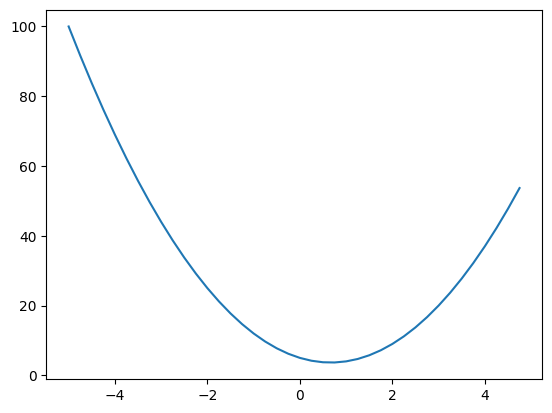

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

In [27]:
# compute derivative through limits
h = 0.00001
x = 2/3
d = (f(x + h) - f(x)) / h
d

3.0000002482211127e-05

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [64]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c

h = 0.001
d1 = a*b+c
c+=h
d2 = a*b+c
(d2 - d1) / h

0.9999999999994458

In [4]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) -1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, int) or isinstance(other, float), 'pow: second argument must be an integer'
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other -1) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node in visited:
                return
            visited.add(node)
            for n in node._prev:
                build_topo(n)
            topo.append(node)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [85]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e=a*b; e.label='e'
    d=e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e=a*b; e.label='e'
    d=e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

1.000000000000334


In [5]:
L.grad = 1.0
draw_dot(L)

NameError: name 'L' is not defined

In [84]:
f.grad = 4.0
d.grad = -2.0

In [89]:
c.grad = -2.0
e.grad = -2.0

In [91]:
a.grad = 6
b.grad = -4

In [93]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a * b
d = c + e
L = d * f

print(L.data)

-7.286496


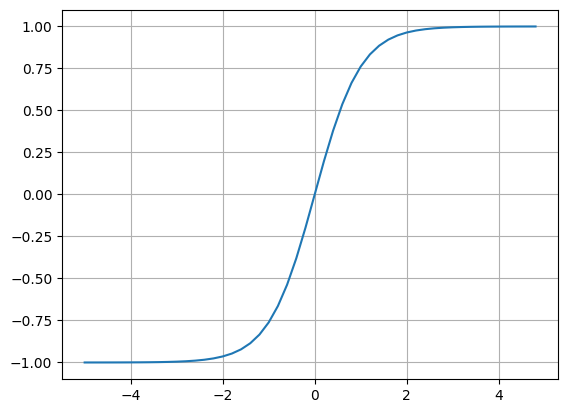

In [6]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

In [7]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b = Value(6.88137358701195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;  x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


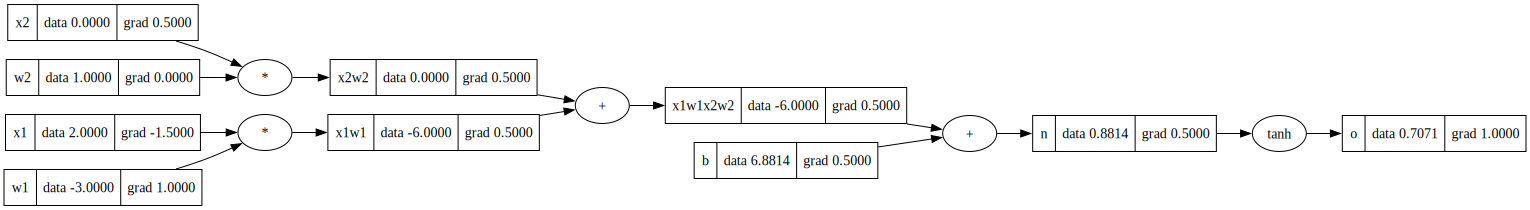

In [8]:
o.backward()
draw_dot(o)

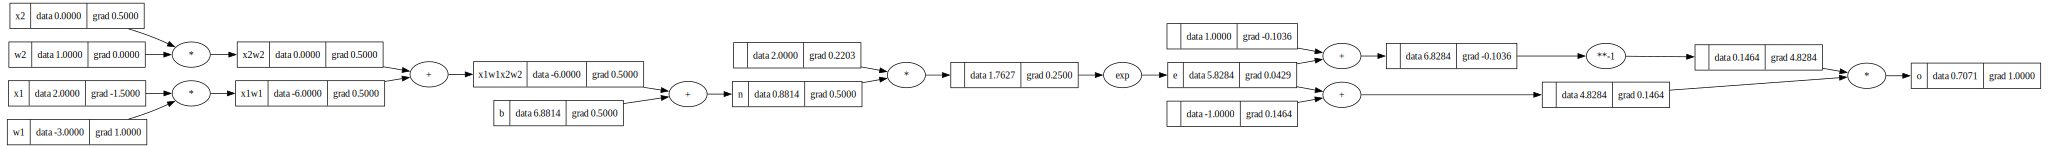

In [9]:
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
b = Value(6.88137358701195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;  x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp(); e.label = 'e'

o = (e - 1.0) / (e + 1.0); o.label = 'o'

o.backward()
draw_dot(o)

In [10]:
import torch

In [11]:
x1=torch.Tensor([2.0]).double(); x1.requires_grad = True
x2=torch.Tensor([0.0]).double(); x2.requires_grad = True
w1=torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2=torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137358701195432]).double(); b.requires_grad = True

n = x1*w1+x2*w2 + b

o = torch.tanh(n)
print(o.data.item())
o.backward()

print(x1.grad.item(), x2.grad.item(), w1.grad.item(), w2.grad.item(), b.grad.item())


0.7071066904050358
-1.5000003851533106 0.5000001283844369 1.0000002567688737 0.0 0.5000001283844369


In [14]:
torch.Tensor([[1,2,3], [4,5,6]])


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [80]:
import random
from typing import List


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):

        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin: int, nout: List[int]):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
m = MLP(3, [4, 4, 1])
m(x)
len(m.parameters())

41

In [ ]:
draw_dot(m(x))

In [480]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]
ys = [1.0, -1.0, -1.0, 1.0]

m = MLP(3, [4, 4, 1])
m(xs[0])


Value(data=-0.873039421002406)

In [551]:
for k in range(1000):        
    ypred = [m(x) for x in xs]
    loss = sum(((yout-ygt)**2 for ygt,yout in zip(ys, ypred)), Value(0))
    for p in m.parameters():
        p.grad = 0.0
    loss.backward()
    for p in m.parameters():
        p.data += -0.1 * p.grad    
    print(k, loss.data)

0 0.0002776348721121063
1 0.00027752453535077296
2 0.0002774437946298946
3 0.0002773697929266787
4 0.00027729905428048403
5 0.0002772350970075147
6 0.0002771639995526832
7 0.00027704559704545053
8 0.00027693660988830325
9 0.0002768661114944868
10 0.0002767950247087622
11 0.0002766862531544716
12 0.00027657768882054836
13 0.00027650053022968904
14 0.0002764253409942271
15 0.00027635736250138294
16 0.0002762853581182201
17 0.00027621218561432254
18 0.00027613559857493094
19 0.0002760262148924189
20 0.0002759494410555327
21 0.0002758324705353981
22 0.0002757622116858942
23 0.0002756512531804611
24 0.00027557782819560936
25 0.00027548394376438324
26 0.0002754092740124641
27 0.0002753368602857469
28 0.0002753037551147464
29 0.000275194874080461
30 0.00027508726212111136
31 0.0002750140266567442
32 0.00027490621830870824
33 0.0002748359320719466
34 0.0002747596510385159
35 0.0002746882379627572
36 0.0002746193666689249
37 0.000274591271937542
38 0.00027451518254822846
39 0.000274442284330037

In [552]:
ypred

[Value(data=0.9929391019317807),
 Value(data=-0.9951206740623509),
 Value(data=-0.9906253238515889),
 Value(data=0.9925159490400186)]